In [64]:
import importlib
from pathlib import Path

import numpy as np
import pandas as pd

import config
import module

try:
    importlib.reload(config)  # reload module
except NameError:
    pass

try:
    importlib.reload(module)  # reload module
except NameError:
    pass

In [65]:
# load DFs
path_attendance = (
    Path.cwd().parents[0]
    / f'data - coco class session and attendance/data/{config.month}/data attendance {" ".join(string for string in config.month.split(" ")[1:])}.xlsx'
)
path_session = (
    Path.cwd().parents[0]
    / f'data - coco class session and attendance/data/{config.month}/data session {" ".join(string for string in config.month.split(" ")[1:])}.xlsx'
)
path_trainer = (
    Path.cwd().parents[0]
    / f"data - coco class session and attendance/input/coco_trainer_data.xlsx"
)
path_noncoco = "input/Non-Coco Class Tracker - 2023 (New).xlsx"

path_coco_member = "input/Member Population.xlsx"

df_att = pd.read_excel(path_attendance)
df_sess = pd.read_excel(path_session)
df_trainer = pd.read_excel(path_trainer, sheet_name=config.month)
df_noncoco = pd.read_excel(
    path_noncoco, sheet_name=config.month_noncoco, engine="openpyxl"
)
df_member = pd.read_excel(path_coco_member)

# Clean and Merge DF

## DF Session

In [66]:
# add data source column to df_sess
# drop index column
# sort column alphabetically
df_sess= (df_sess
    .assign(data_source= 'coco')
    .drop(columns= 'index')
    .loc[:, lambda df_: sorted(df_.columns)]
)

## DF Noncoco

In [67]:
# map center to area
list_center = df_sess.groupby(["class_area", "class_location"]).size().index.to_list()
map_center = {center: area for (area, center) in list_center}

# map class service
map_service = {
    "Deluxe": "Deluxe",
    "Deluxe + Go": "Deluxe & Go",
    "Deluxe & Go": "Deluxe & Go",
    "VIP": "VIP",
    "IELTS": "Other",
    "Proskill": "Other",
    "Club": "Other",
    "Other": "Other",
    "Prospect": "Other",
    "GO": "Go",
    "Go": "Go",
    np.nan: "Other",
}


# clean df noncoco
df_noncoco_cleaned = (
    df_noncoco
    # get only necessary columns
    .loc[
        :,
        [
            "Teacher",
            "Class Date",
            "Class Time",
            "Class Type",
            "Class Location",
            "Class Service",
            "Class Attendance",
            "Class Booking",
            "Class Description",
            "Class Duration",
            "Class Status",
        ],
    ].rename(columns=lambda c: c.lower().replace(" ", "_"))
    # if the teacher is na, drop the rows
    .dropna(subset="teacher")
    # note: clean columns
    .assign(
        class_type=lambda df_: (
            df_["class_type"]
            .str.strip()
            .fillna("Other")
            .replace("Deluxe + Go", "Deluxe & Go")
        ),
        class_date=lambda df_: pd.to_datetime(df_["class_date"]),
        # get first 4 digits of the time
        class_time=lambda df_: df_["class_time"].astype(str).str[:5],
        teacher=lambda df_: df_["teacher"].astype(str).str.strip(),
        # map class service
        class_service=lambda df_: df_["class_service"].map(map_service),
        # if class_status == na, fill with given
        class_status=lambda df_: df_["class_status"].fillna("Given"),
        class_description=lambda df_: df_["class_description"].str.lower(),
        # fill missing class duration with 1
        class_duration=lambda df_: df_["class_duration"].fillna(1),
        # cast class attendance into float
        class_attendance=lambda df_: pd.to_numeric(
            df_["class_attendance"], errors="coerce"
        ),
    )
    # note: create new columns
    .assign(
        data_source="noncoco",
        class_mode=lambda df_: np.where(
            df_["class_type"].str.lower().str.contains("online"), "Online", "Offline"
        ),
        class_type_grouped=lambda df_: module.create_class_type_noncoco(
            df_, "class_type", "class_mode", "class_service"
        ),
    )
    # if online, make class location online
    # map the class location
    .assign(
        class_location=lambda df_: module.clean_online_class_location(df_),
        class_area=lambda df_: df_["class_location"].map(map_center).fillna("Other"),
    )
    # drop rows where class date is not current month
    .loc[lambda df_: df_["class_date"].dt.month == config.month_number]
    # merge with df trainer to get teacher center and area
    .merge(df_trainer, how="left", on="teacher")
    # drop unused columns
    .drop(columns=["teacher_note_1", "teacher_note_2", "teacher_working_days"])
    # sort column alphabetically
    .loc[:, lambda df_: sorted(df_.columns)]
    # drop null cols
    .dropna(how="all", axis=0)
    # .dropna(how= 'all', axis= 1)
    .loc[:, lambda df_: ~df_.columns.str.contains("Unnamed")]
)
df_noncoco_cleaned.head(3)

,class_area,class_attendance,class_booking,class_date,class_description,class_duration,class_location,class_mode,class_service,class_status,class_time,class_type,class_type_grouped,data_source,teacher,teacher_area,teacher_center,teacher_position
0,Online,NaN,NaN,2023-12-01,fl go,2.0,Online,Online,Go,Given,0.583,Online FL,Online First Lesson,noncoco,Saputri Okfitasari Hana,JKT 3,CBB,Coach
1,JKT 3,NaN,NaN,2023-12-01,chat hour material prep (send to stewart),1.0,CBB,Offline,Other,Given,0.75,Other,Other,noncoco,Saputri Okfitasari Hana,JKT 3,CBB,Coach
2,JKT 3,NaN,NaN,2023-12-01,grammar video explanation,1.0,CBB,Offline,Other,Given,0.791,Other,Other,noncoco,Saputri Okfitasari Hana,JKT 3,CBB,Coach


## Merge DF

In [68]:
# merge df session and df noncoco
df_sess_full = pd.concat([df_sess, df_noncoco_cleaned], axis=0)
df_sess_full = (
    df_sess_full.reset_index(drop=True)
    .assign(index=lambda df_: df_.index + 1)
    .assign(
        class_duration=lambda df_: pd.to_numeric(df_["class_duration"], errors="raise"),
        class_grouping=lambda df_: df_["class_type_grouped"].map(module.class_grouping),
    )
)
df_sess_full.shape

(4744, 20)

## Assertions

In [69]:
# ! assert that online class is done online (in location)
filter_1 = df_noncoco_cleaned["class_type"].str.lower().str.contains("online")
filter_2 = df_noncoco_cleaned["class_description"].str.lower().str.contains("online")
filter_3 = df_noncoco_cleaned["class_mode"] == "Online"
filter_4 = df_noncoco_cleaned["class_service"] == "Go"

# (df_noncoco_cleaned
#     .loc[
#         (filter_1 | filter_2 | filter_3 | filter_4) & (df_noncoco_cleaned["class_location"] != "Online")
#     ]
# )
assert (
    df_noncoco_cleaned.loc[filter_1 | filter_2 | filter_3 | filter_4, "class_location"]
    != "Online"
).sum() == 0

# check if df sess column = df noncoco column
try:
    if (df_sess.columns != df_noncoco_cleaned.columns).any():
        print(f"Coco: {df_sess.columns}")
        print(f"Coco: {df_noncoco_cleaned.columns}")
        raise Exception("Columns unequal")
except ValueError:
    print("Column length differs.")
    print(f"Coco: {df_sess.columns}")
    print(f"Coco: {df_noncoco_cleaned.columns}")

# check if all class types are grouped
types = df_sess_full["class_type_grouped"].unique()
for t in types:
    ungrouped=False
    if t not in module.class_grouping.keys():
        print(t)
        ungrouped = True
if ungrouped:
    raise Exception("Some class types are ungrouped. Insert into module.class_grouping.")

# Sheet 1: Center Attendance
Experience/data - coco center attendance

# Sheet 2: Activity Diagram
Experience/data - coco member activity diagram

# Sheet 3: Class Session & util

In [70]:
class_session = (
    df_sess_full
    # ! exclude GOC
    .loc[df_sess_full["class_mode"] != "GOC"]
    .groupby(["class_grouping", "class_mode", "class_type_grouped"])
    .agg(
        total_scheduled_session=("index", "nunique"),
        # count how many rows have status "Given"
        total_delivered_session=("class_status", lambda c: (c == "Given").sum()),
        # use sum first because to obtain avg, have to divide sum by num of classes
        total_attendance=("class_attendance", "sum"),
    )
    # assign max attendance per class type
    .assign(
        max_attendance=lambda df_: df_.index.get_level_values(2).map(
            module.class_target
        )
    )
    .astype("Int64")
    .assign(
        avg_attendance=lambda df_: df_["total_attendance"]
        .div(df_["total_delivered_session"])
        .round(1),
        avg_per_max_attendance=lambda df_: df_["avg_attendance"]
        .div(df_["max_attendance"])
        .round(2),
    )
    # sort index top place "Other" below
    .sort_index(level=0, ascending=False)
    .assign(
        percentage_delivered=lambda df_: df_["total_delivered_session"]
        .div(df_["total_scheduled_session"])
        .astype(float)
        .round(2),
    )
    .rename(columns=lambda c: c.replace("_", " ").title())
    .rename_axis(["", "Class Mode", "Class Type Grouped"])
    .loc[
        :,
        [
            "Total Scheduled Session",
            "Total Delivered Session",
            "Percentage Delivered",
            "Max Attendance",
            "Avg Attendance",
            "Avg Per Max Attendance",
        ],
    ]
)

# TODO: if avg attendance < 1,
class_session

Total Scheduled Session  \
         Class Mode Class Type Grouped                                      
VIP      Online     Online VPG                                        125   
                    Online One-on-one                                 376   
         Offline    VPG                                                56   
                    One-on-one                                        413   
Standard Online     Online Social Club                                215   
                    Online First Lesson                                47   
                    Online Complementary                              345   
                    Online Community                                   32   
                    Online Advising Session                             3   
         Offline    Social Club                                       323   
                    Member's Party                                      1   
                    First Lesson                                       70   
                    Complementary                                     346   
                    Community                                          72   
                    Chat Hour                                         228   
                    Advising Session                                   45   
Other    Online     Online Proskill First Lesson                        2   
                    Online Proskill                                     1   
                    Online Other                                        9   
                    Online IELTS First Lesson                           6   
                    Online IELTS                                        4   
         Offline    Proskill                                            3   
                    Other                                             147   
                    Mock Test                                           7   
                    IELTS                                               7   

                                                  Total Delivered Session  \
         Class Mode Class Type Grouped                                      
VIP      Online     Online VPG                                         86   
                    Online One-on-one                                 213   
         Offline    VPG                                                54   
                    One-on-one                                        290   
Standard Online     Online Social Club                                213   
                    Online First Lesson                                45   
                    Online Complementary                              341   
                    Online Community                                   32   
                    Online Advising Session                             2   
         Offline    Social Club                                       307   
                    Member's Party                                      1   
                    First Lesson                                       67   
                    Complementary                                     314   
                    Community                                          70   
                    Chat Hour                                         225   
                    Advising Session                                   41   
Other    Online     Online Proskill First Lesson                        2   
                    Online Proskill                                     1   
                    Online Other                                        6   
                    Online IELTS First Lesson                           6   
                    Online IELTS                                        4   
         Offline    Proskill                                            3   
                    Other                                             140   
                    Mock Test                

# Sheet 4: ET Util

In [71]:
et_excluded= [
]

In [72]:
et_util = (
    df_sess_full
    # merge with df trainer to get working days etc
    .merge(df_trainer, how="left", on="teacher")
    # ! exclude et if less than 1 month
    .loc[lambda df_: ~(df_['teacher'].isin(et_excluded))]
    # to calculate class duration for delivered only,
    # create a temp column
    # if given, leave, if not given, 0
    .assign(
        class_duration_delivered=lambda df_: np.where(
            df_["class_status"] == "Given", df_["class_duration"], 0
        )
    )
    .groupby(["teacher_position_y", "teacher_area_x", "teacher"])
    .agg(
        working_days=("teacher_working_days", "mean"),
        total_scheduled_hours=("class_duration", "sum"),
        total_delivered_hours=("class_duration_delivered", "sum"),
    )
    # filter only for ET and coach
    .loc[
        lambda df_: df_.index.get_level_values("teacher_position_y").isin(
            ["ET", "Coach"]
        )
    ]
    .assign(
        working_days=lambda df_: df_["working_days"].astype("Int64"),
        total_scheduled_hours=lambda df_: df_["total_scheduled_hours"].astype(int),
        total_delivered_hours=lambda df_: df_["total_delivered_hours"].astype(int),
        scheduled_hours_per_day=lambda df_: (
            df_["total_scheduled_hours"].div(df_["working_days"]).round(1)
        ),
        delivered_hours_per_day=lambda df_: (
            df_["total_delivered_hours"].div(df_["working_days"]).round(1)
        ),
        max_class_hours=lambda df_: module.create_max_hour_per_trainer(df_),
        scheduled_utilization=lambda df_: df_["scheduled_hours_per_day"]
        .div(df_["max_class_hours"])
        .round(2),
        delivered_utilization=lambda df_: df_["delivered_hours_per_day"]
        .div(df_["max_class_hours"])
        .round(2),
    )
    # filer utilization below 0.5 (does not make sense)
    # .loc[lambda df_: df_["scheduled_utilization"] >= 0.5]
    .rename(columns=lambda c: c.replace("_", " ").title())
    .rename_axis(["Teacher Position", "Teacher Area", "Teacher"])
)
print(et_util.shape)
et_util

(34, 8)


Working Days  \
Teacher Position Teacher Area Teacher                                          
Coach            BDG          Mustikawati Eka                             20   
                 JKT 1        Hamsah Handayani Ratnasari                  21   
                              Mordechai Kaleb Arthur                      20   
                              Oktavia Cindy                               21   
                              Rifani Aurora Nurhidayah                    21   
                 JKT 2        Cahyani Ani Rahma                           18   
                              Fairuz Muhammad                             20   
                              Hazisyah Alifia Nur                         22   
                              Khalisa Fairuz Putri                        20   
                              Rozak Abdul Rahman                          21   
                 JKT 3        Ansyahputri Anggita Rizkiarachma            19   
                              Hundoyo Tri Bekti                           18   
                              Medianti Annisa                             17   
                              Prasheena Kainaz                            20   
                              Saputri Okfitasari Hana                     20   
                              Waney Natalia Christy                       18   
                 SBY          Melody Grace                                17   
                              Murti Gitasya                               20   
ET               BDG          Lawrence Moore John                         18   
                 JKT 1        Algar Sinclair Alexander John               12   
                              Basuki Imelda                               19   
                              Gereau Jason Jarett                         13   
                              Jane Quinn Madeline                         15   
                              Tinggogoy Anna Maria                        20   
                 JKT 2        Handayani Khaerunisyah Risma                21   
                              Johanson Brian                              17   
                              Jurado Michael John                         21   
                              Phillips Toby                               16   
                 JKT 3        Lee Platel Connor                           22   
                              Morris Stewart James                        12   
                              Pratama Dimas Indra                         16   
                              Rahmadya Nova Ayu                           22   
                              Sutcliffe Christopher                       20   
                 SBY          Jones Jack William Isaac                    21   

                                                                Total Scheduled Hours  \
Teacher Position Teacher Area Teacher                                                   
Coach            BDG          Mustikawati Eka                                      91   
                 JKT 1        Hamsah Handayani Ratnasari                          101   
                              Mordechai Kaleb Arthur                               96   
                              Oktavia Cindy                                        89   
                              Rifani Aurora Nurhidayah                             87   
                 JKT 2        Cahyani Ani Rahma                                    81   
                              Fairuz Muhammad                                      64   
                              Hazisyah Alifia Nur                                  95   
                              Khalisa Fairuz Putri                                 58   
                              Rozak Abdul Rahman                                   60   
                 JKT 3        Ansyahputri Anggita Rizkiarachma                     69   
                          

# Sheet 5: Ooolab

In [215]:
ooolab= (df_sess_full
    .loc[df_sess_full['teacher_center'] == 'Ooolab']
    .groupby(['class_service', 'class_mode', 'class_type_grouped', 'class_type'])
    .size()
    .to_frame()
    .rename(columns= {0: 'count'})
    .rename(columns= lambda c: c.replace('_', ' ').title())
    .rename_axis(['Class Service', 'Class Mode', 'Class Type Grouped', 'Class Type'])
)
ooolab

Count
Class Service Class Mode Class Type Grouped   Class Type                  
Deluxe & Go   Online     Online Complementary Online Complementary     129
                         Online Social Club   Online Social Club        98
VIP           Online     Online VPG           Online Complementary       6
                                              Online English Corner     94

# Sheet 6: Community

In [216]:
def create_class(df, column):
    conditions= [
        df[column].str.lower().str.contains('cre-8|cre 8|cre8'),
        df[column].str.lower().str.contains('syndicate'),
        df[column].str.lower().str.contains('re-charge|re charge|recharge'),
        df[column].str.lower().str.contains('leap'),
    ]
    choices= [
        'CRE-8',
        'Syndicate',
        'Re-Charge',
        'Leap'
    ]
    result= np.select(conditions, choices, default= 'NONE')
    return result

def create_class_type(df, column):
    conditions= [
        df[column].str.lower().str.contains('meetup|meet up|meet-up|met up|mee t up'),
        df[column].str.lower().str.contains('workshop|work shop'),
        df[column].str.lower().str.contains('showcase|show case|swowcase'),
    ]
    choices= [
        'Meet Up', 
        'Workshop',
        'Showcase'
    ]
    result= np.select(conditions, choices, default= 'NONE')
    return result

communities= 'cre-8|cre 8|cre8|syndicate|re-charge|re charge|recharge|leap'

In [217]:
df_comm= (df_sess
    # filter for community
    .loc[df_sess['class_type_grouped'].isin(['Online Community', 'Community'])]
    .assign(
        # create com name
        community_name= lambda df_: create_class(df_, 'class_description'),
        # create com class type
        community_class_type= lambda df_: create_class_type(df_, 'class_description'),
    )
    .groupby(['community_name', 'community_class_type', 'class_mode'])
    .agg(
        # get avg attendance
        avg_attendance= ('class_attendance', 
                         lambda x: x.mean().round(1))
    )
    .reset_index()
    .pivot(
        columns= 'community_name', 
        index= ['community_class_type', 'class_mode']
    )
    .transpose()
    .rename_axis(['', ''], axis= 1)
    .rename_axis(['', ''], axis= 1)
    .reset_index()
    .drop(columns= 'level_0', level= 0)
    .rename(columns= {'community_name': 'Community'})
)
df_comm

Community Meet Up        Showcase        Workshop       
             Offline Online  Offline Online  Offline Online
0      CRE-8     5.2   21.2     13.0   16.0      6.4   11.3
1       Leap     6.6   22.2      NaN   50.0      7.1   24.7
2  Re-Charge     5.4   14.0      NaN   34.0      6.5   21.0
3  Syndicate     8.1   15.5     21.0   60.0      7.5   13.0

In [218]:
df_comm_full= (df_sess
    # filter for community
    .loc[df_sess['class_type_grouped'].isin(['Online Community', 'Community'])]
    .assign(
        # create com name
        community_name= lambda df_: create_class(df_, 'class_description'),
        # create com class type
        community_class_type= lambda df_: create_class_type(df_, 'class_description'),
    )
    .groupby(['community_name', 'community_class_type', 'class_mode'])
    .agg(
        total_scheduled_session= ('community_class_type', 'count'),
        total_delivered_session= ('class_status', lambda i: (i=='Given').sum()),
        total_attendance= ('class_attendance', 'sum'),
        avg_attendance= ('class_attendance', 'mean')
    )
    .assign(
        avg_attendance= lambda df_: df_['avg_attendance'].round(1),
        percentage_delivered= lambda df_: df_['total_delivered_session'].div(df_['total_scheduled_session']).round(2)
    )
    [['total_scheduled_session', 'total_delivered_session', 'percentage_delivered', 'total_attendance', 'avg_attendance']]
    .rename(columns= lambda c: c.replace('_', ' ').title())
    .rename_axis(['Community', 'Class Type', 'Class Mode'])
)
df_comm_full.head()

Total Scheduled Session  \
Community Class Type Class Mode                            
CRE-8     Meet Up    Offline                           9   
                     Online                            4   
          Showcase   Offline                           1   
                     Online                            1   
          Workshop   Offline                           9   

                                 Total Delivered Session  \
Community Class Type Class Mode                            
CRE-8     Meet Up    Offline                           9   
                     Online                            4   
          Showcase   Offline                           1   
                     Online                            1   
          Workshop   Offline                           9   

                                 Percentage Delivered  Total Attendance  \
Community Class Type Class Mode                                           
CRE-8     Meet Up    Offline                      1.0                47   
                     Online                       1.0                85   
          Showcase   Offline                      1.0                13   
                     Online                       1.0                16   
          Workshop   Offline                      1.0                58   

                                 Avg Attendance  
Community Class Type Class Mode                  
CRE-8     Meet Up    Offline                5.2  
                     Online                21.2  
          Showcase   Offline               13.0  
                     Online                16.0  
          Workshop   Offline                6.4

# Sheet 7: Member Cohort

In [219]:
# create a date range from jan 2023 to current month
date_ranges = pd.date_range(
    "2023-01-01",
    pd.to_datetime(month, format="%m %b %Y") + pd.offsets.MonthEnd(0),
    freq="m",
    inclusive="both",
)

# create a date range from jan 2023 to current month in a readable format
month_ranges = [i.strftime("%m %b %Y").lower() for i in date_ranges]

# list of all att files
att_files = [
    Path.cwd().parents[1]
    / f"data - coco class session and attendance v2/{i}/data attendance {i[3:]}.xlsx"
    for i in month_ranges
]

# get all att files and concat
dfs = []
for file in att_files:
    try:
        df = pd.read_excel(
            file, usecols=["student_code", "class_date", "student_attendance"]
        )
        dfs.append(df)
    except FileNotFoundError:
        pass
df_att_all = pd.concat(dfs, ignore_index=True)

In [220]:
cohort_start_month = pd.to_datetime(month, format="%m %b %Y") - pd.Timedelta(days=365)
cohort_end_month = pd.to_datetime(month, format="%m %b %Y") + pd.offsets.MonthEnd(0)

print(f"cohort start :{cohort_start_month: '%d %b %Y'}, cohort end :{cohort_end_month: '%d %b %Y'}")

cohort start : '01 Nov 2022', cohort end : '30 Nov 2023'


In [221]:
# attendance of all member
df_att_all_clean = (df_att_all
    .loc[lambda df_: df_["student_attendance"] == "Attend"] # only attend
    .drop(columns=["student_attendance"])
    .rename(columns={"class_date": "date"})
    # ! loc attendance between cohort start and end
    .loc[
        lambda df_: (df_["date"] >= cohort_start_month) & (df_["date"] <= cohort_end_month)
    ]
)

# the date on which the member join
df_member_clean = (df_member
    .loc[
        lambda df_: df_["start_date"] >= "2023-01-01", 
        ["student_code", "start_date"]
    ]
    .rename(columns={"start_date": "date"})
    .assign(is_first=True)
    # ! loc date between cohort start and end
    .loc[
        lambda df_: (df_["date"] >= cohort_start_month) & (df_["date"] <= cohort_end_month)
    ]
)

# concat att and member
df_cohort_raw = (pd.concat([df_member_clean, df_att_all_clean])
    # ! drop the same date 
    .sort_values(["is_first", "date"])
    .drop_duplicates(subset=["student_code", "date"], keep="first")
    .drop(columns=["is_first"])
    .assign(date=lambda df_: pd.to_datetime(df_["date"]))
    .rename(columns={"student_code": "customer_id", "date": "transaction_date"})
)

In [222]:
df_cohort = module.make_cohort(df_cohort_raw, do_check_cohort=False)

/home/anj/Drive/wse/2. Experience/data - experience management report/src/module.py:180: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["first_purchase", "days_after_first_transaction"])


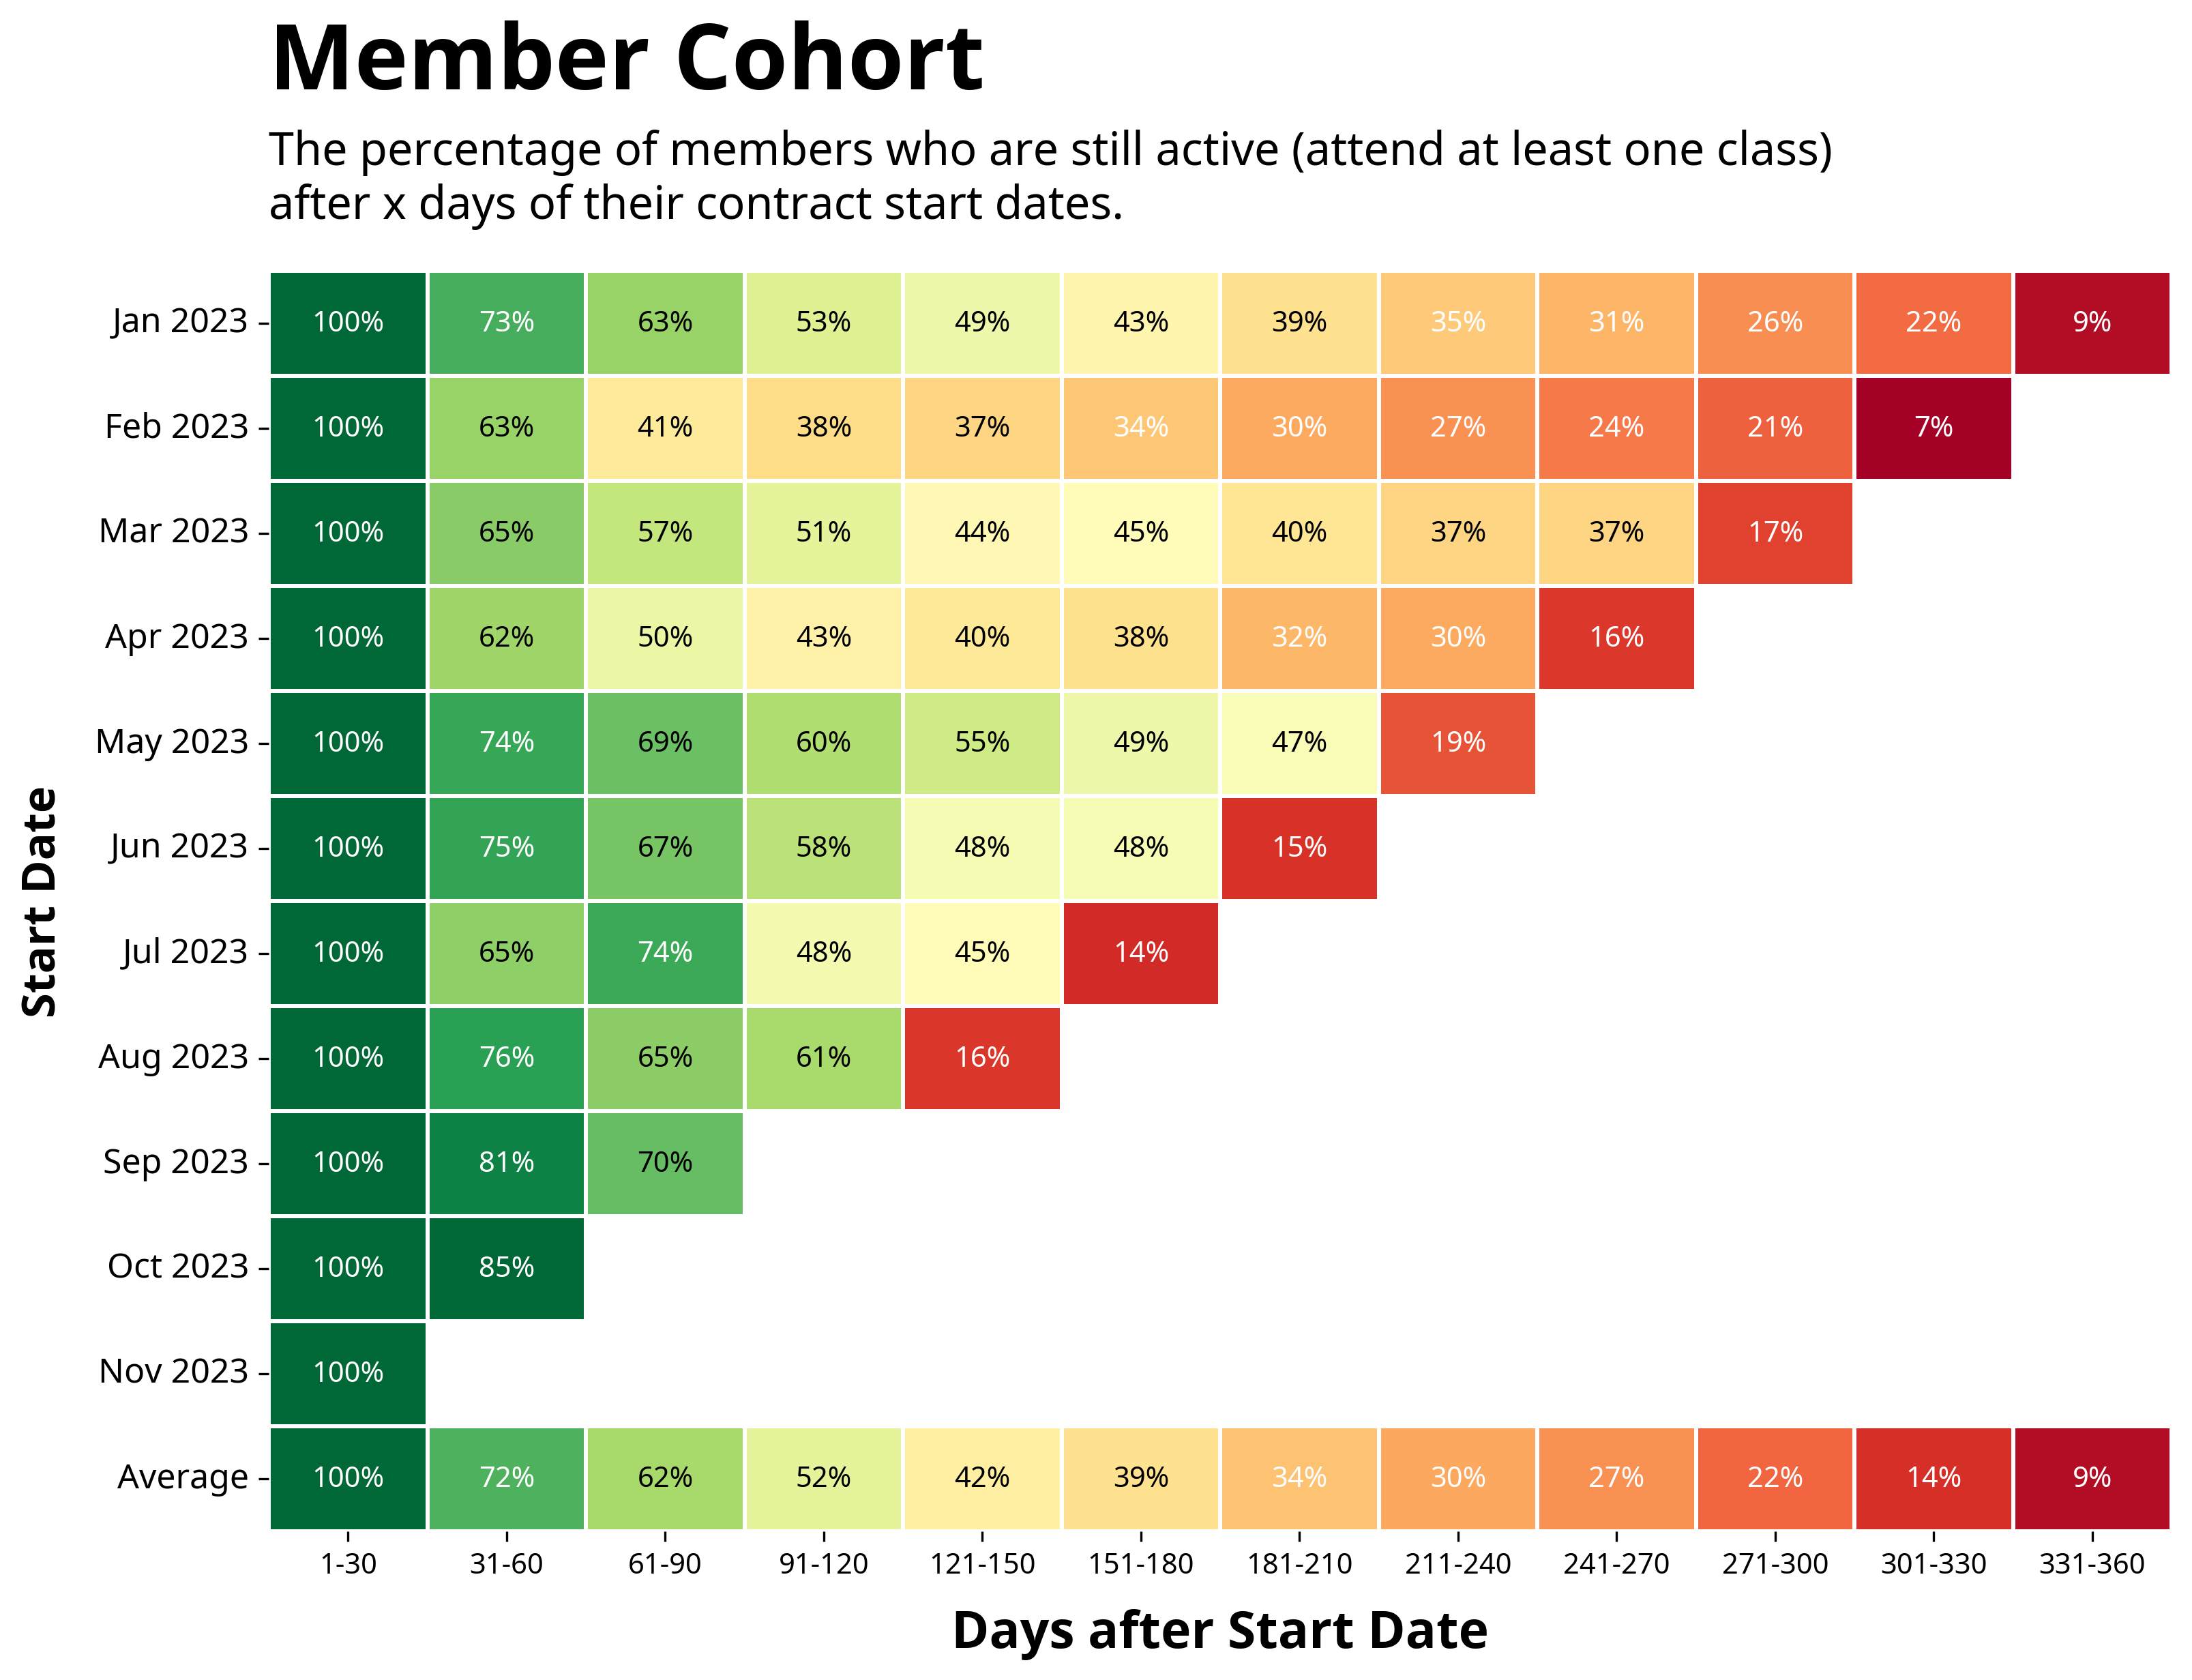

In [223]:
module.plot_cohort(df_cohort)

# Data: Class Mapping

In [224]:
df_class_mapping= (df_sess_full
    # ! exclude GOC
    .loc[df_sess_full['class_mode'] != 'GOC']
    .assign(class_grouping= lambda df_: df_['class_type_grouped'].map(class_grouping))
    .groupby(['class_grouping', 'class_mode', 'class_type_grouped', 'class_type'])
    .agg(
        total_scheduled_session= ('index', 'nunique'),
        # count how many rows have status "Given"
        total_delivered_session= ('class_status', lambda c: (c == 'Given').sum()),
    )
    .rename_axis(['Class Grouping', 'Class Mode', 'Class Type Grouped', 'Class Type'])
    .rename(columns= lambda c: c.replace('_', ' ').title())
)

# Assertion

In [225]:
# ! assert that area center and pos is not null

mask= (df_sess_full[['teacher_area', 'teacher_center', 'teacher_position']]
    .isna()
    .astype(float)
    .sum(axis= 1)
    .astype(bool)
)

null= df_sess_full[mask]
if len(null) > 0:
    raise Exception('Area, center and position are unmapped.')

In [226]:
df_sess_full.loc[df_sess_full['teacher_area'].isna(), 'teacher'].unique()

array([], dtype=object)

# Save DF

In [227]:
def save_multiple_dfs(list_df, list_sheet_name, filepath):
    """save multiple dfs to one file with multiple sheets

    Args:
        list_df (list): list of dataframe objects
        list_sheet_name (list): list of string for sheet name
        filepath (string): path of file
    """
    import xlsxwriter
    writer = pd.ExcelWriter(filepath, engine= 'xlsxwriter')

    for df in list_df:
        df.to_excel(writer, sheet_name= list_sheet_name.pop(0), index= True)

    writer.close()

path= Path.cwd().parents[0] / f'output/Experience Management Report (Source Code) - {month_noncoco}.xlsx'
sheets= [
    'Center Attendance', 
    'Activity Diagram', 
    'GOC', 
    'Class Session & Utilization', 
    'ET Utilization',
    'Community Class',
    'Community Class - Full',
    'Ooolab',
    'Data - Session',
    'Data - Class Mapping'
]
dfs= [
    pd.DataFrame(), 
    pd.DataFrame(), 
    pd.DataFrame(), 
    class_session, 
    et_util, 
    df_comm, 
    df_comm_full,
    ooolab,
    df_sess_full,
    df_class_mapping
]
 
import os
if not os.path.exists(path):
    save_multiple_dfs(dfs, sheets, path)
    print('File saved.')
else:
    print('File already exist.')

File already exist.


# Experiment

In [228]:
# # check why some class durations are missing
# df_sess_full.loc[(df_sess_full['class_duration'].isna()) | (df_sess_full['class_duration'] == 0)]

In [229]:
# # check why there are records from prev months
# df_sess_full['class_date'].dt.month.value_counts(dropna= False)

In [230]:
teachers = [
   "Algar Sinclair Alexander John",
   "Gereau Jason Jarett",
   "Jane Quinn Madeline",
   "Johanson Brian",
   "Lee Platel Connor",
   "Rozak Abdul Rahman",
   "Sutcliffe Christopher",
]
for teacher in teachers:
    result = (df_sess_full
        .loc[df_sess_full['teacher'] == teacher, ['class_date', 'class_time', 'class_duration']]
        .drop_duplicates()
        .assign(class_hour= lambda df_: df_['class_time'].astype(str).str[:2])
        .groupby('class_date')
        .agg(
            class_hour= ('class_hour', lambda x: ', '.join(x)),
            total_hours= ('class_duration', 'sum')
        )
        .loc[lambda df_: df_['total_hours'] <= 6]
        .reset_index()
        .assign(
                class_date=lambda df_: df_["class_date"].dt.strftime("%d %b"), 
                total_hours=lambda df_: df_["total_hours"].astype(int)
        )
    )
    print(teacher)
    print(result.to_markdown(), end="\n\n")

Algar Sinclair Alexander John
|    | class_date   | class_hour             |   total_hours |
|---:|:-------------|:-----------------------|--------------:|
|  0 | 01 Nov       | 12, 13, 16, 17, 19, 20 |             6 |
|  1 | 02 Nov       | 18, 19, 20, 12, 13     |             6 |
|  2 | 03 Nov       | 12, 14, 15, 20, 18     |             6 |
|  3 | 04 Nov       | 12, 13, 16, 17, 18, 14 |             6 |
|  4 | 07 Nov       | 13, 15, 16, 18, 19, 20 |             6 |
|  5 | 08 Nov       | 13, 14, 15, 17, 19, 20 |             6 |
|  6 | 09 Nov       | 12, 14, 15, 18, 19, 20 |             6 |
|  7 | 10 Nov       | 14, 15, 16, 20, 18     |             6 |
|  8 | 11 Nov       | 12, 13, 16, 17, 19, 20 |             6 |
|  9 | 14 Nov       | 12, 15, 16, 18, 19, 20 |             6 |
| 10 | 15 Nov       | 15, 20, 16, 12, 18     |             6 |
| 11 | 16 Nov       | 12, 13, 16, 18, 19, 20 |             6 |
| 12 | 17 Nov       | 13, 15, 16, 20, 18     |             6 |
| 13 | 18 Nov       | 12,